In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline


In [2]:
stroke_risk = pd.read_csv('../00-data/healthcare-dataset-stroke-data.csv')

stroke_risk

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
to_remove = ['id']
to_1he = ['work_type', 'smoking_status']
to_01 = ['gender', 'Residence_type', 'ever_married']
to_normalize = ['age', 'avg_glucose_level', 'bmi']

mapping_dict = {
    'gender': {'Male': 1, 'Female': 0},
    'Residence_type': {'Urban': 1, 'Rural': 0},
    'ever_married': {'Yes': 1, 'No': 0}
}

In [4]:
stroke_risk_cp  = stroke_risk.copy()
stroke_risk_cp = stroke_risk_cp.drop(to_remove, axis=1)
stroke_risk_cp

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [5]:
stroke_risk_cp = pd.get_dummies(stroke_risk_cp, columns=to_1he, drop_first=True)
for col in to_01:
  stroke_risk_cp[col] = stroke_risk_cp[col].map(mapping_dict[col])

In [6]:
stroke_risk_cp

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,67.0,0,1,1,1,228.69,36.6,1,False,True,False,False,True,False,False
1,0.0,61.0,0,0,1,0,202.21,NaN,1,False,False,True,False,False,True,False
2,1.0,80.0,0,1,1,0,105.92,32.5,1,False,True,False,False,False,True,False
3,0.0,49.0,0,0,1,1,171.23,34.4,1,False,True,False,False,False,False,True
4,0.0,79.0,1,0,1,0,174.12,24.0,1,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0.0,80.0,1,0,1,1,83.75,NaN,0,False,True,False,False,False,True,False
5106,0.0,81.0,0,0,1,1,125.20,40.0,0,False,False,True,False,False,True,False
5107,0.0,35.0,0,0,1,0,82.99,30.6,0,False,False,True,False,False,True,False
5108,1.0,51.0,0,0,1,0,166.29,25.6,0,False,True,False,False,True,False,False


In [7]:
stroke_risk_cp.isnull().sum()

gender                              1
age                                 0
hypertension                        0
heart_disease                       0
ever_married                        0
Residence_type                      0
avg_glucose_level                   0
bmi                               201
stroke                              0
work_type_Never_worked              0
work_type_Private                   0
work_type_Self-employed             0
work_type_children                  0
smoking_status_formerly smoked      0
smoking_status_never smoked         0
smoking_status_smokes               0
dtype: int64

In [8]:
stroke_cleaned = stroke_risk_cp[~stroke_risk_cp['bmi'].isnull()]
stroke_cleaned_null = ~stroke_risk_cp['gender'].isnull()
stroke_cleaned = stroke_cleaned[stroke_cleaned_null]

stroke_cleaned

C:\Users\David\AppData\Local\Temp\ipykernel_35588\2759396873.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stroke_cleaned = stroke_cleaned[stroke_cleaned_null]


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,67.0,0,1,1,1,228.69,36.6,1,False,True,False,False,True,False,False
2,1.0,80.0,0,1,1,0,105.92,32.5,1,False,True,False,False,False,True,False
3,0.0,49.0,0,0,1,1,171.23,34.4,1,False,True,False,False,False,False,True
4,0.0,79.0,1,0,1,0,174.12,24.0,1,False,False,True,False,False,True,False
5,1.0,81.0,0,0,1,1,186.21,29.0,1,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,13.0,0,0,0,0,103.08,18.6,0,False,False,False,True,False,False,False
5106,0.0,81.0,0,0,1,1,125.20,40.0,0,False,False,True,False,False,True,False
5107,0.0,35.0,0,0,1,0,82.99,30.6,0,False,False,True,False,False,True,False
5108,1.0,51.0,0,0,1,0,166.29,25.6,0,False,True,False,False,True,False,False


In [9]:
stroke_cleaned.isnull().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
stroke                            0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [10]:
X = stroke_cleaned.drop(['stroke'], axis=1).values

y = stroke_cleaned['stroke'].values

print(f'X: {X.shape}, y: {y.shape}')

X: (4908, 15), y: (4908,)


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape},')

X_train: (3435, 15), X_test: (1473, 15), Y_train: (3435,), Y_test: (1473,),


In [12]:
forest = RandomForestClassifier(n_estimators=30, max_depth=8, random_state=False, class_weight='balanced_subsample')

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

ACCURACY: TRAIN=0.9135 TEST=0.8819


In [13]:

def create_confusion_matrix(y, y_pred):
  cm = confusion_matrix(y, y_pred)
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
              # xticklabels=['Predetto Negativo (No Ictus)', 'Predetto Positivo (Ictus)'],
              # yticklabels=['Reale Negativo (No Ictus)', 'Reale Positivo (Ictus)']
              )
  plt.xlabel('Previsione')
  plt.ylabel('Verità')
  plt.title('Matrice di Confusione')
  plt.show()


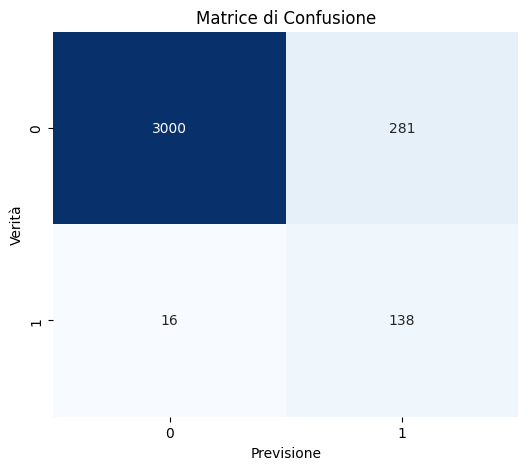

In [14]:
create_confusion_matrix(Y_train, y_pred_train)

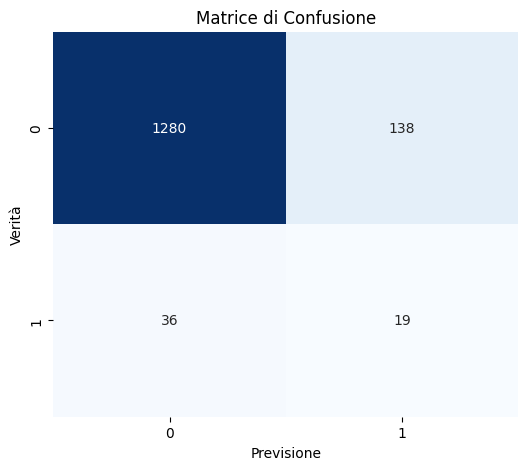

In [15]:
create_confusion_matrix(Y_test, y_pred)

In [16]:
forest = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=False, class_weight='balanced_subsample')

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

ACCURACY: TRAIN=0.7476 TEST=0.7366


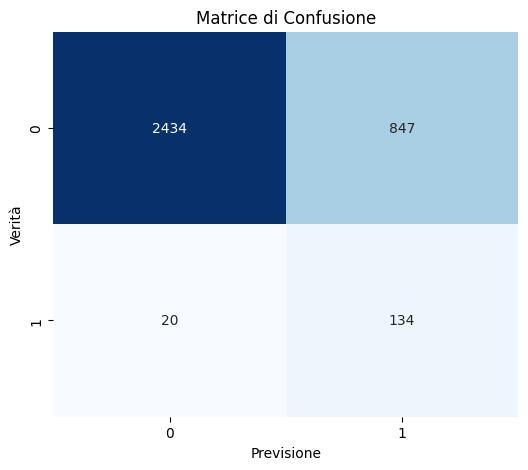

In [17]:
create_confusion_matrix(Y_train, y_pred_train)

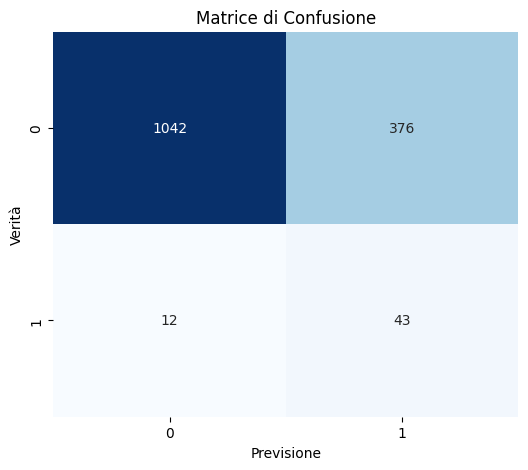

In [18]:
create_confusion_matrix(Y_test, y_pred)

In [19]:
min_ages = [0, 45,50,55,60, 65, 70, 75, 80]

for min_age in min_ages:
  print(f'min_age: {min_age}')
  stroke_risk_year = stroke_cleaned[stroke_cleaned['age'] >= min_age]
  stroke_risk
  
  X_year = stroke_cleaned[stroke_cleaned['age'] >= min_age].drop(['stroke'], axis=1).values
  y_year = stroke_cleaned[stroke_cleaned['age'] >= min_age]['stroke'].values
  
  X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(X_year, y_year, test_size=0.2, random_state=42)
  
  forest = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=False, class_weight='balanced_subsample')

  forest.fit(X_train_year, y_train_year)

  y_pred_train = forest.predict(X_train_year)
  y_pred = forest.predict(X_test_year)

  accuracy_train = accuracy_score(y_train_year, y_pred_train)
  accuracy_test = accuracy_score(y_test_year, y_pred)

  # print('train:')
  # print(classification_report(y_train_year, y_pred_train))
  # print('test:')
  print(classification_report(y_test_year, y_pred))
  # print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
  # print('confusion matrix train')
  # create_confusion_matrix(y_train_year, y_pred_train)
  
  # print('confusion matrix test')
  # create_confusion_matrix(y_test_year, y_pred)
  print('-------------------------------------------------------')

min_age: 0
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       929
           1       0.15      0.57      0.24        53

    accuracy                           0.81       982
   macro avg       0.56      0.69      0.57       982
weighted avg       0.93      0.81      0.85       982

-------------------------------------------------------
min_age: 45
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       452
           1       0.14      0.24      0.17        37

    accuracy                           0.83       489
   macro avg       0.54      0.56      0.54       489
weighted avg       0.87      0.83      0.85       489

-------------------------------------------------------
min_age: 50
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       383
           1       0.16      0.29      0.21        35

    accuracy                       

le classi sono sbilanciate, provo ad usare smote

In [20]:
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, Y_train)

forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')

forest.fit(X_train_resampled, y_train_resampled)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print(classification_report(Y_test, y_pred))


ACCURACY: TRAIN=0.9750 TEST=0.9599
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1418
           1       0.30      0.05      0.09        55

    accuracy                           0.96      1473
   macro avg       0.63      0.52      0.54      1473
weighted avg       0.94      0.96      0.95      1473



In [21]:
pipe_example = Pipeline([
  ('oversampler', SMOTE(random_state=42, k_neighbors=7, sampling_strategy=1)),
  ('classifier', RandomForestClassifier(random_state=42, n_estimators=500, max_depth=10, class_weight='balanced'))
])

In [22]:
pipe_example.fit(X_train, Y_train)

y_pred_train_resambled_base = pipe_example.predict(X_train)
y_pred_test_resambled_base = pipe_example.predict(X_test)

classification_train = classification_report(Y_train, y_pred_train_resambled_base)
classification_test = classification_report(Y_test, y_pred_test_resambled_base)

print('train')
print(classification_train)
print('test')
print(classification_test)

train
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3281
           1       0.90      0.55      0.68       154

    accuracy                           0.98      3435
   macro avg       0.94      0.77      0.83      3435
weighted avg       0.98      0.98      0.97      3435

test
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1418
           1       0.25      0.05      0.09        55

    accuracy                           0.96      1473
   macro avg       0.61      0.52      0.53      1473
weighted avg       0.94      0.96      0.95      1473



provo con al gridsearch

In [23]:
pipeline_example = Pipeline([
    ('sampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Esempio di griglia di parametri
param_grid_example = {
    'sampler__k_neighbors': [3, 5],
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10]
}

# Esempio di scorer per la classe minoritaria
f1_scorer_example = make_scorer(f1_score, pos_label=1)

# Esempio di Cross-Validation stratificata
cv_strategy_example = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inizializza GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_example,       # La tua pipeline
    param_grid=param_grid_example,    # La griglia dei parametri da esplorare
    scoring=f1_scorer_example,        # La metrica per valutare e scegliere il migliore
    cv=cv_strategy_example,           # La strategia di cross-validation
    n_jobs=-1,                        # Opzionale: usa tutti i core della CPU per accelerare
    verbose=2                         # Opzionale: mostra un output dettagliato durante l'esecuzione
)

In [24]:
grid_search.fit(X_train, Y_train)

best_model = grid_search.best_estimator_



Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [25]:
best_model

Pipeline(steps=[('sampler', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])

In [26]:
best_model.fit(X_train, Y_train)

y_pred_train_best_model = best_model.predict(X_train)
y_pred_test_best_model = best_model.predict(X_test)

best_model_train = classification_report(Y_train, y_pred_train_best_model)
best_model_test = classification_report(Y_test, y_pred_test_best_model)

print('train')
print(best_model_train)
print('test')
print(best_model_test)

train
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      3281
           1       0.27      0.51      0.35       154

    accuracy                           0.91      3435
   macro avg       0.62      0.72      0.65      3435
weighted avg       0.94      0.91      0.93      3435

test
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1418
           1       0.13      0.27      0.17        55

    accuracy                           0.90      1473
   macro avg       0.55      0.60      0.56      1473
weighted avg       0.94      0.90      0.92      1473



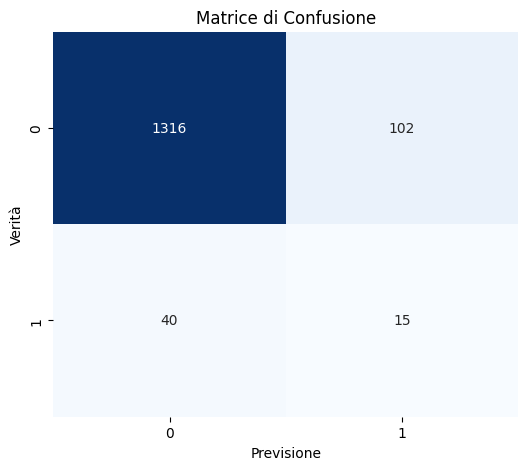

In [27]:
create_confusion_matrix(Y_test, y_pred_test_best_model)